# Pneumonia detectation

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import random #escolher imagens aleatórias
import tensorflow as tf
from tensorflow import keras

## Import Datasets and checking folder paths

In [3]:
# projetar o caminho do dataset
base_path = '../../data/processed/chest_xray'

In [4]:
# usar o os.path.join pra fazer os caminhos corretos
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')
#pastas de validação
val_path = os.path.join(base_path, 'val')

In [5]:
# confirmar os caminhos
if os.path.exists(train_path) and os.path.exists(test_path):
    print(f"Pasta de treino e teste encontradas em: {os.path.abspath(base_path)}")
    #verificar se a validação existe tb
    if os.path.exists(val_path):
        print(f"Pasta val encontrada")
    else:
        print("Pasta não encontrada")
else:
    print(f"Pastas de treino e testes não encontradas no caminho: {os.path.abspath(base_path)}")

Pasta de treino e teste encontradas em: c:\Users\ianfe\OneDrive\Área de Trabalho\Projeto Genese\data\processed\chest_xray
Pasta val encontrada


## Counting files

In [6]:
train_normal_path = os.path.join(train_path, 'NORMAL')
train_pneumonia_path = os.path.join(train_path, 'PNEUMONIA')

test_normal_path = os.path.join(test_path, 'NORMAL')
test_pneumonia_path = os.path.join(test_path, 'PNEUMONIA')

In [7]:
#counting
try:
    num_train_normal = len(os.listdir(train_normal_path))
    num_train_pneumonia = len(os.listdir(train_pneumonia_path))
    num_test_normal = len(os.listdir(test_normal_path))
    num_test_pneumonia = len(os.listdir(test_pneumonia_path))

    print(f"Train set:")
    print(f" - Normal: {num_train_normal} images.")
    print(f" - Pneumonia: {num_train_pneumonia} images.")

    print(f"Test set")
    print(f" - Normal {num_test_normal} images.")
    print(f" - Pneumonia {num_test_pneumonia} images.")

    total_train = num_train_normal + num_train_pneumonia
    total_test = num_test_normal + num_test_pneumonia
    print(f"\nTotal Train: {total_train}")
    print(f"Total Test:  {total_test}")
    print(f"Total:  {total_train + total_test}")

    #balancing analysis
    if abs(num_train_normal - num_train_pneumonia) > 0.1 * total_train:
        print(f"WARNING: Dataset of train is desbalancing (Normal: {num_train_normal}, Pneumonia: {num_train_pneumonia})")
    else:
        print("Train set balanced")

    if abs(num_test_normal - num_test_pneumonia) > 0.1 * total_test:
        print(f"WARNING: Dataset of test is desbalancing (Normal: {num_test_normal}, Pneumonia: {num_test_pneumonia})")
    else:
        print("Test set balanced")

except FileNotFoundError as e:
    print(f"\nERROR: One of the subfolders (Normal or Pneumonia)  was not found")
    print(f"Error detail: {e}")
except Exception as e:
    print(f"\nERROR during counting: {e}")
     

Train set:
 - Normal: 1341 images.
 - Pneumonia: 3875 images.
Test set
 - Normal 234 images.
 - Pneumonia 390 images.

Total Train: 5216
Total Test:  624
Total:  5840


In [8]:
def show_random_samples(path, title, num_samples=3): #(caminho, titulo, numero de exemplos)
    #usar try ... except pra encontrar possiveis erros
    try:
        all_filenames = os.listdir(path) #pega todos os nomes dos arquivos
        filenames_to_show = random.sample(all_filenames, num_samples)

        plt.figure(figsize=(10, 4))
        plt.suptitle(f'Amostras de: {title}', fontsize=14)

        for i, fname in enumerate(filenames_to_show): #loop que passa por cada nome de arquivo / i = contador (0, 1, 2), fname = nome do arquivo
            img_path = os.path.join(path, fname) # constroi o caminho pra imagem atual
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE) #carrega a imagem em tons de cinza

            plt.subplot(1, num_samples, i + 1)
            plt.imshow(img, cmap='gray')
            plt.title(f'Example {i + 1}')
            plt.axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show

    #possiveis erros
    except FileNotFoundError:
        print(f'ERROR: The {path} file was not found')
    except ValueError:
        print(f"WARNING: In the {path} file, has less than {num_samples} images for show")
    except Exception as e:
        print(f"Unexpected ERROR while viewing samples '{path}': {e}")

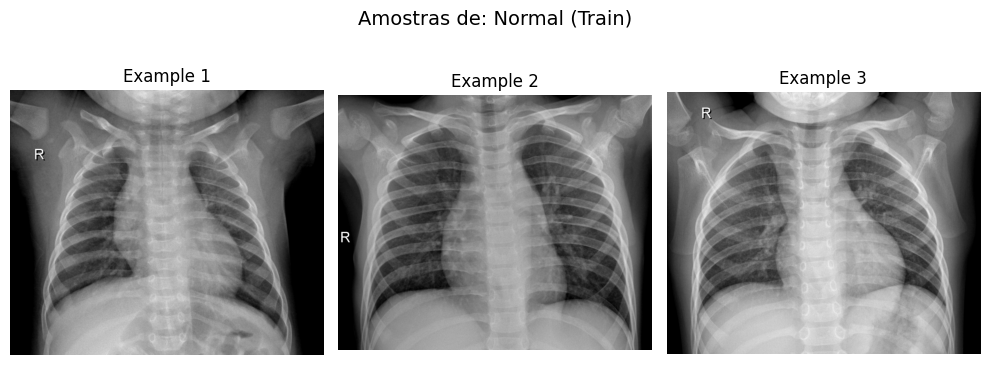

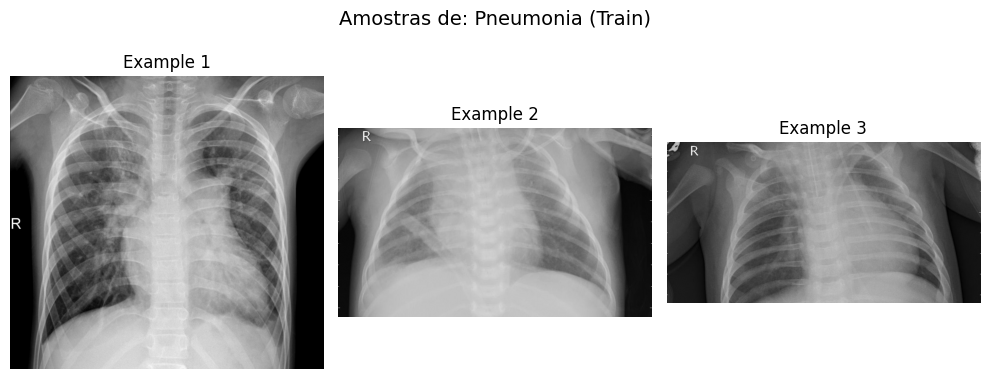

In [9]:
show_random_samples(train_normal_path, 'Normal (Train)')
show_random_samples(train_pneumonia_path, 'Pneumonia (Train)')

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [12]:
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 32

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode = 'binary',
    color_mode = 'grayscale'
)

print(f"Encontradas {train_generator.samples} imagens pertencentes a {train_generator.num_classes} classes.")
# Ele também mapeia os nomes das pastas ('NORMAL', 'PNEUMONIA') para índices (0, 1).
print(f"Mapeamento de classes: {train_generator.class_indices}")

Found 5216 images belonging to 2 classes.
Encontradas 5216 imagens pertencentes a 2 classes.
Mapeamento de classes: {'NORMAL': 0, 'PNEUMONIA': 1}


In [13]:
# agora dataset de teste
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode = 'binary',
    color_mode = 'grayscale',
    shuffle=False
)

print(f"Encontradas {test_generator.samples} imagens pertencentes a {test_generator.num_classes} classes.")
print(f"Mapeamento de classes: {test_generator.class_indices}") # Deve ser o mesmo do treino.

Found 624 images belonging to 2 classes.
Encontradas 624 imagens pertencentes a 2 classes.
Mapeamento de classes: {'NORMAL': 0, 'PNEUMONIA': 1}


In [14]:
from tensorflow.keras import layers
from tensorflow.keras import models

In [15]:
model = models.Sequential()


In [16]:
model.add(layers.Conv2D(32, (3, 3), activation = 'relu', input_shape=(150, 150, 1)))
model.add(layers.MaxPooling2D((2, 2)))

c:\Users\ianfe\OneDrive\Área de Trabalho\Projeto Genese\venv\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [17]:
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

In [18]:
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

In [19]:
model.add(layers.Flatten())

In [20]:
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

In [21]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,033,601 (72.61 MB)

 Trainable params: 19,033,601 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=4,
    validation_data=test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE
)

c:\Users\ianfe\OneDrive\Área de Trabalho\Projeto Genese\venv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/4
163/163 ━━━━━━━━━━━━━━━━━━━━ 99s 590ms/step - accuracy: 0.9076 - loss: 0.2302 - val_accuracy: 0.7105 - val_loss: 1.0123
Epoch 2/4
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 501ms/step - accuracy: 0.9676 - loss: 0.0934 - val_accuracy: 0.7780 - val_loss: 0.7309
Epoch 3/4
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 507ms/step - accuracy: 0.9741 - loss: 0.0765 - val_accuracy: 0.7237 - val_loss: 1.6650
Epoch 4/4
163/163 ━━━━━━━━━━━━━━━━━━━━ 85s 522ms/step - accuracy: 0.9791 - loss: 0.0592 - val_accuracy: 0.7681 - val_loss: 1.0442


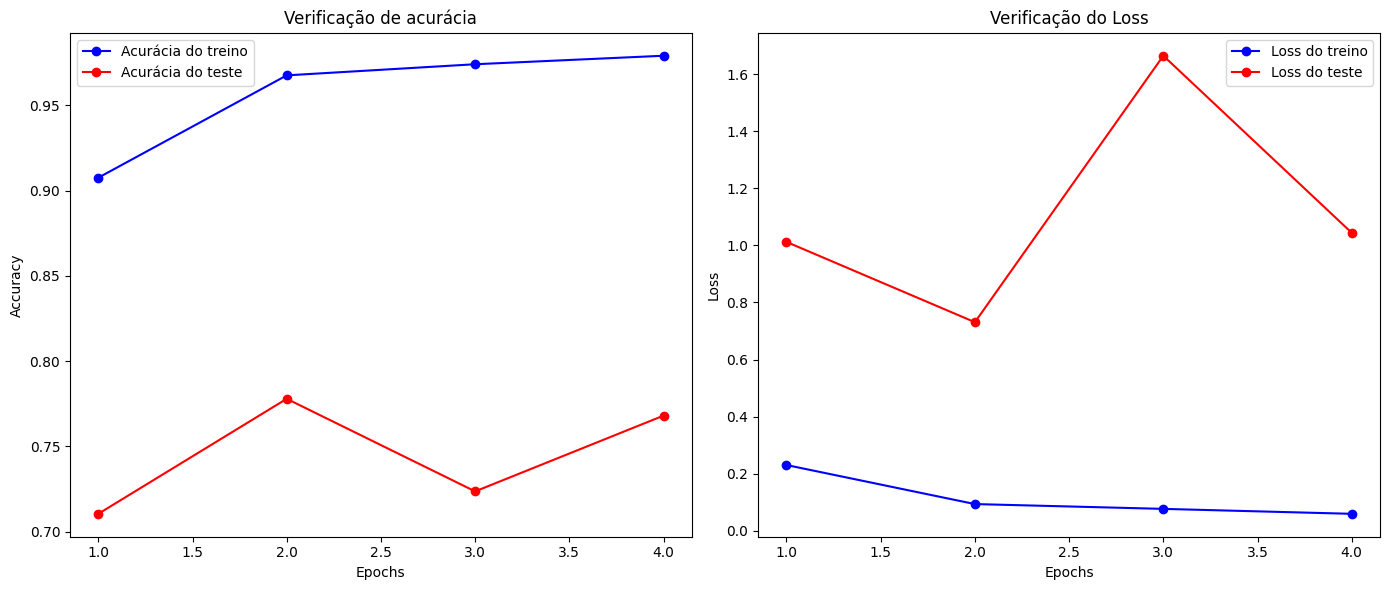

In [24]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, len(acc) + 1)

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, 'bo-', label='Acurácia do treino')
plt.plot(epochs_range, val_acc, 'ro-', label='Acurácia do teste')
plt.title('Verificação de acurácia')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, 'bo-', label='Loss do treino')
plt.plot(epochs_range, val_loss, 'ro-', label='Loss do teste')
plt.title('Verificação do Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

In [25]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose = 1)
print(f"Loss no conjunto de testes: {test_loss:.4f}")
print(f"Acurácia no conjunto de testes: {test_accuracy * 100:.2f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 229ms/step - accuracy: 0.7681 - loss: 1.0442
Loss no conjunto de testes: 1.0442
Acurácia no conjunto de testes: 76.81


### Applying EarlyStopping method for prevent overfitting

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

In [27]:
model_earlystop = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

In [28]:
model_earlystop.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [29]:
early_stopping_monitor = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

In [30]:
EPOCHS_MAX = 50

history_long = model_earlystop.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs= EPOCHS_MAX,
    validation_data = test_generator,
    validation_steps=test_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping_monitor]
)

stopped_epoch = early_stopping_monitor.stopped_epoch
if stopped_epoch > 0:
    print(f"O treinamento parou no epoch: {stopped_epoch + 1}")
else:
    print(f"O modelo parou de treinar na quantia máxima: {EPOCHS_MAX}")

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 89s 530ms/step - accuracy: 0.9216 - loss: 0.1957 - val_accuracy: 0.7993 - val_loss: 0.5889
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 86s 527ms/step - accuracy: 0.9670 - loss: 0.0911 - val_accuracy: 0.8076 - val_loss: 0.5881
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 139s 510ms/step - accuracy: 0.9734 - loss: 0.0752 - val_accuracy: 0.7961 - val_loss: 0.8539
Epoch 4/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 511ms/step - accuracy: 0.9801 - loss: 0.0522 - val_accuracy: 0.7615 - val_loss: 1.1965
Epoch 5/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 82s 500ms/step - accuracy: 0.9864 - loss: 0.0397 - val_accuracy: 0.7582 - val_loss: 1.2693
O treinamento parou no epoch: 5


In [31]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE, verbose = 1)
print(f"Loss no conjunto de testes: {test_loss:.4f}")
print(f"Acurácia no conjunto de testes: {test_accuracy * 100:.2f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 278ms/step - accuracy: 0.7681 - loss: 1.0442
Loss no conjunto de testes: 1.0442
Acurácia no conjunto de testes: 76.81


In [32]:
print("\n--- Avaliando a Performance Final do Modelo com EarlyStopping ---")
print("Usando o conjunto de teste...")

# Chamamos model.evaluate(), passando o GERADOR de dados de teste.
# IMPORTANTE: Estamos usando o modelo 'model_earlystop', que foi treinado com o vigia.
test_loss_es, test_accuracy_es = model_earlystop.evaluate(
    test_generator,                                     # O gerador com os dados de teste.
    steps=test_generator.samples // BATCH_SIZE,         # Calcula quantos lotes processar para ver todo o teste set.
    verbose=1                                           # Mostra a barra de progresso.
)

print("\n--- Resultado Final da Avaliação (com EarlyStopping) ---")
# Imprime a loss final no teste. Esperamos que seja MENOR que o 5.0 de antes.
print(f"Loss no Conjunto de Teste:    {test_loss_es:.4f}") 
# Imprime a acurácia final no teste. Esperamos que seja MAIOR que os 74% de antes.
print(f"Acurácia no Conjunto de Teste: {test_accuracy_es * 100:.2f}%")

# --- Comparativo Rápido ---
# (Se você ainda tiver os valores antigos 'test_loss' e 'test_accuracy' na memória)
try:
    print("\n--- Comparativo com o Treino Anterior (sem EarlyStopping) ---")
    print(f"Acurácia Anterior: {test_accuracy * 100:.2f}% | Acurácia Nova: {test_accuracy_es * 100:.2f}%")
    print(f"Loss Anterior:     {test_loss:.4f}      | Loss Nova:     {test_loss_es:.4f}")
    if test_accuracy_es > test_accuracy:
        print(">>> O EarlyStopping MELHOROU a performance real do modelo! <<<")
    else:
        print(">>> O EarlyStopping não melhorou a performance (ou piorou). Pode ser necessário ajustar parâmetros. <<<")
except NameError:
    # Caso as variáveis antigas não existam mais na memória.
    print("\n(Variáveis do treino anterior não encontradas para comparação direta)")


--- Avaliando a Performance Final do Modelo com EarlyStopping ---
Usando o conjunto de teste...
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 253ms/step - accuracy: 0.8076 - loss: 0.5881

--- Resultado Final da Avaliação (com EarlyStopping) ---
Loss no Conjunto de Teste:    0.5881
Acurácia no Conjunto de Teste: 80.76%

--- Comparativo com o Treino Anterior (sem EarlyStopping) ---
Acurácia Anterior: 76.81% | Acurácia Nova: 80.76%
Loss Anterior:     1.0442      | Loss Nova:     0.5881
>>> O EarlyStopping MELHOROU a performance real do modelo! <<<


In [33]:
model_dropout = models.Sequential()

model_dropout.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 1)))
model_dropout.add(layers.MaxPooling2D((2, 2)))
model_dropout.add(layers.Conv2D(64, (3, 3), activation='relu'))
model_dropout.add(layers.MaxPooling2D((2, 2)))
model_dropout.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_dropout.add(layers.MaxPooling2D((2, 2)))

model_dropout.add(layers.Flatten())

model_dropout.add(layers.Dense(512, activation='relu'))
model_dropout.add(layers.Dropout(0.5))
model_dropout.add(layers.Dense(1, activation='sigmoid'))

In [34]:
model_dropout.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 148, 148, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 34, 34, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │    18,940,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,033,601 (72.61 MB)

 Trainable params: 19,033,601 (72.61 MB)

 Non-trainable params: 0 (0.00 B)

In [35]:
model_dropout.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [36]:
EPOCHS = 15

history = model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data = test_generator,
    validation_steps = test_generator.samples // BATCH_SIZE,
)

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 77s 471ms/step - accuracy: 0.9824 - loss: 0.0502 - val_accuracy: 0.7500 - val_loss: 1.3270
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 74s 453ms/step - accuracy: 0.9877 - loss: 0.0333 - val_accuracy: 0.7599 - val_loss: 1.4648
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 462ms/step - accuracy: 0.9891 - loss: 0.0267 - val_accuracy: 0.7451 - val_loss: 2.0028
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 460ms/step - accuracy: 0.9939 - loss: 0.0162 - val_accuracy: 0.7533 - val_loss: 2.1149
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 486ms/step - accuracy: 0.9937 - loss: 0.0163 - val_accuracy: 0.7122 - val_loss: 2.4614
Epoch 6/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 81s 498ms/step - accuracy: 0.9946 - loss: 0.0155 - val_accuracy: 0.7582 - val_loss: 1.9068
Epoch 7/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 83s 507ms/step - accuracy: 0.9937 - loss: 0.0173 - val_accuracy: 0.7648 - val_loss: 1.9492
Epoch 8/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 465ms/step - accuracy: 0.9977 - loss: 0

In [39]:
history_dropout = model_dropout.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // BATCH_SIZE,
    epochs = EPOCHS_MAX,
    validation_data = test_generator,
    validation_steps = test_generator.samples // BATCH_SIZE,
    callbacks=[early_stopping_monitor]
)

stopped_epoch_dropout = early_stopping_monitor.stopped_epoch
if stopped_epoch_dropout > 0:
    print(f"O treinamento parou antecipadamente na epoch {stopped_epoch_dropout + 1}") 
    print(f"Os pesos foram restaurados para a epoch com a menor val_loss.")
else:
    print(f"O treinamento completou todas as {EPOCHS_MAX} epochs.")

Epoch 1/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 79s 472ms/step - accuracy: 0.8947 - loss: 0.2624 - val_accuracy: 0.7401 - val_loss: 0.8805
Epoch 2/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 75s 459ms/step - accuracy: 0.9643 - loss: 0.1122 - val_accuracy: 0.7664 - val_loss: 0.7988
Epoch 3/50
163/163 ━━━━━━━━━━━━━━━━━━━━ 76s 464ms/step - accuracy: 0.9655 - loss: 0.0996 - val_accuracy: 0.7582 - val_loss: 1.1762
O treinamento parou antecipadamente na epoch 3
Os pesos foram restaurados para a epoch com a menor val_loss.


In [40]:
best_epoch_idx = stopped_epoch_dropout if stopped_epoch_dropout > 0 else EPOCHS_MAX - 1

best_epoch_idx = max(0, best_epoch_idx - early_stopping_monitor.patience)


if best_epoch_idx < len(history_dropout.history['val_loss']):
    best_val_loss = history_dropout.history['val_loss'][best_epoch_idx]
    best_val_acc = history_dropout.history['val_accuracy'][best_epoch_idx]
    print(f"\nMétricas aproximadas da melhor epoch (Epoch ~{best_epoch_idx+1}):")
    print(f"  - Melhor val_loss:    {best_val_loss:.4f}")
    print(f"  - Melhor val_accuracy: {best_val_acc * 100:.2f}%")
else:
    print("\nNão foi possível obter métricas da melhor época diretamente do histórico.")
    print("Vamos avaliar no conjunto de teste para ver a performance final.")


Métricas aproximadas da melhor epoch (Epoch ~1):
  - Melhor val_loss:    0.8805
  - Melhor val_accuracy: 74.01%


In [42]:
test_loss_dropout, test_accuracy_dropout = model_dropout.evaluate(
    test_generator,
    steps = test_generator.samples // BATCH_SIZE,
    verbose = 1
)

print(f"Conjunto do loss: {test_loss_dropout:.4f}")
print(f"Conjunto de acurácia: {test_accuracy_dropout * 100:.2f}%")

try:
    print(f"\nAcurácia anterior (ES): {test_accuracy_es * 100:.2f}% | Acurácia nova: {test_accuracy_dropout * 100:.2f}%")
    print(f"\nLoss anterior: {test_loss_es:.4f} | Loss atual: {test_loss_dropout:.4f}")
    if test_accuracy_dropout > test_accuracy_es:
        print("O DropOut melhorou a perfomance")
    elif test_accuracy_dropout == test_accuracy_es:
        print("O DropOut não mudou a perfomance")
    elif test_accuracy_dropout < test_accuracy_es:
        print("O DropOut piorou a perfomance")
except NameError:
    print("\nVariaveis de treinos anteriores não encontrada")


19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 213ms/step - accuracy: 0.7401 - loss: 0.8805
Conjunto do loss: 0.8805
Conjunto de acurácia: 74.01%

Acurácia anterior (ES): 80.76% | Acurácia nova: 74.01%

Loss anterior: 0.5881 | Loss atual: 0.8805
O DropOut piorou a perfomance
